In [1]:
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['savefig.transparent'] = True
sns.set_theme(style="whitegrid")
palette = ['tab:blue', 'tab:green', 'tab:red']
hue_order = ['PMC', 'SZ', 'SWING']
sns.set(rc={"figure.figsize":(14, 6)})

def plot_te(df, dataset_name, metric='nrmse'):
    df = df[(df.data == dataset_name) & (df.metric == metric)]
    df.compression = df.compression.str.upper()
    sns.set(rc={"figure.figsize":(6, 4)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")

    fig, ax1 = plt.subplots()
    # display(df)
    ax = sns.lineplot(data=df, x='eb', y='decompression error', hue='compression', hue_order=hue_order, palette=palette, ax=ax1)
    plt.legend(title='', fontsize='18')
    ax.set(xlabel='error bound', ylabel='transformation error NRMSE')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)

    ax.set_xlim(0, 0.8)
    # ax.set_ylim(0, 0.23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    plt.tight_layout()
    plt.savefig('../figures/aus_eb_de.pdf')


def plot_cr(df, dataset_name):
    df = df[(df.data == dataset_name)]
    df.compression = df.compression.str.upper()
    # df.gzip = np.log2(df.gzip.values)
    df.rename({'gzip': 'compression ratio'}, axis=1, inplace=True)
    sns.set(rc={"figure.figsize":(6, 4)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")

    fig, ax1 = plt.subplots()

    ax = sns.lineplot(data=df, x='error_bound', y='compression ratio', hue='compression', hue_order=hue_order, palette=palette, ax=ax1)
    ax.axhline(np.log2(2.02), ls='--', c='black', label="GORILLA")
    # ax.annotate('raw data',(-0.5, 0),(10,10), textcoords = 'offset pixels')
    plt.yscale('log')
    plt.legend(title='', fontsize='18')
    # ax.set(xlabel='error bound')
    ax.set(xlabel='error bound', ylabel='compression ratio')

    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0,  size=18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)

    ax.set_xlim(0, 0.8)
    # ax.set_ylim(0, 35)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    plt.tight_layout()
    plt.savefig('../figures/aus_eb_cr.pdf')


def plot_compressed_data(data_name, data_dir, ot, ebs):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter('%m-%d')

    subplot = 131
    for eblc in ['pmc', 'swing', 'sz']:
        if 'sz' in eblc:
            ebs = np.asarray(ebs)*0.01
        df = pd.read_parquet(data_dir%eblc)
        data_r = df[f'{ot}-R']
        data_pmc_eb0 = df[f'{ot}-E{ebs[0]}']
        data_pmc_eb1 = df[f'{ot}-E{ebs[1]}']

        sns.set(rc={"figure.figsize":(16, 5.5)})
        matplotlib.rcParams['axes.grid'] = True
        matplotlib.rcParams['savefig.transparent'] = True
        sns.set_theme(style="whitegrid")

        plt.subplot(subplot)
        sns.lineplot(data=data_r[:250], label='OR')
        sns.lineplot(data=data_pmc_eb0[:250], label='e=0.05')
        ax = sns.lineplot(data=data_pmc_eb1[:250], label='e=0.1')

        # ax.xaxis.set_major_locator(days)
        # ax.xaxis.set_major_formatter(years_fmt)
        # ax.xaxis.set_minor_locator(months)

        plt.legend(title='', fontsize='18', loc='lower left')

        ax.set(ylabel='values', xlabel=eblc.upper())

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(18)

        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(18)

        subplot+=1

    plt.tight_layout()
    plt.savefig(f'../figures/{data_name}_compressed.pdf')


def get_tfe(model_results):
    baseline_result  = model_results[model_results.eblc == 'baseline']
    model_results['tfe'] = (model_results.nrmse.values - baseline_result.nrmse.values)/baseline_result.nrmse.values
    baseline_result = baseline_result.append([baseline_result]*2, ignore_index=True)
    baseline_result.at[0, 'eblc'] = 'pmc'
    baseline_result.at[1, 'eblc'] = 'sz'
    baseline_result.at[2, 'eblc'] = 'swing'
    baseline_result['tfe'] = 0.
    return pd.concat([model_results, baseline_result])

def plot_te_tfe_pweather():
    sns.set(rc={"figure.figsize":(6, 5)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")
    pweather_results = pd.read_csv('../results/tfe/processed_weather.csv')
    pweather_results = pweather_results[pweather_results.te <= 0.15]
    ax = sns.lineplot(data=pweather_results,
                      x='te',
                      y='TFE',
                      hue='compression',
                      err_style='bars',
                      palette=palette,
                      hue_order=hue_order
                      )
    plt.legend(title='', fontsize='18', loc='upper left')

    ax.set(ylabel='TFE', xlabel='TE')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    plt.tight_layout()
    plt.savefig(f'../figures/pweather_tfe_all.pdf')


def plot_te_tfe_from_precomp(data, te_bound):
    sns.set(rc={"figure.figsize":(6, 5)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")
    results = pd.read_csv('../results/tfe/all_models_results_.csv')
    results = results[(results.data == data) & (results.te_metric == 'nrmse')]
    results = results[results.te <= te_bound]

    if 'SOLAR' in data:
        results = results[results.model != 'GRU']

    if 'WIND' in data:
        results = results[results.TFE < 0.5]

    ax = sns.lineplot(data=results,
                      x='te',
                      y='TFE',
                      hue='compression',
                      err_style='bars',
                      palette=palette,
                      hue_order=hue_order
                      )
    plt.legend(title='', fontsize='18', loc='upper left')

    ax.set(ylabel='TFE', xlabel='TE')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    ax.set_xlim(0, te_bound)
    plt.tight_layout()
    plt.savefig(f'../figures/{data.lower()}_tfe_all.pdf')


def plot_te_tfe(data_name):
    sns.set(rc={"figure.figsize":(6, 5)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")

    all_results = pd.DataFrame()
    for root, dirs, files in os.walk('../results/tfe/per_model/'):
        for result_file in files:
            print(result_file)
            if 'gru' in result_file:
                continue
            model_results = pd.read_csv(os.path.join(root, result_file))
            model_results = model_results[(model_results.data == data_name) & (model_results.error < 0.045)]
            model_results = get_tfe(model_results)
            all_results = pd.concat([all_results, model_results])


    all_results.reset_index(drop=True, inplace=True)
    all_results.eblc = all_results.eblc.str.upper()
    ax = sns.lineplot(data=all_results,
                      x='error',
                      y='tfe',
                      hue='eblc',
                      err_style='bars',
                      palette=palette,
                      hue_order=hue_order
                      )

    plt.legend(title='', fontsize='18', loc='upper left')

    ax.set(ylabel='TFE', xlabel='TE')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    ax.set_xlim(0, 0.05)
    plt.tight_layout()
    plt.savefig(f'../figures/nogru_{data_name}_tfe_all.pdf')
    plt.show()



arima_results.csv
dlinear_results.csv
gru_results.csv
informer_results.csv
nbeats_results.csv
transformer_results.csv


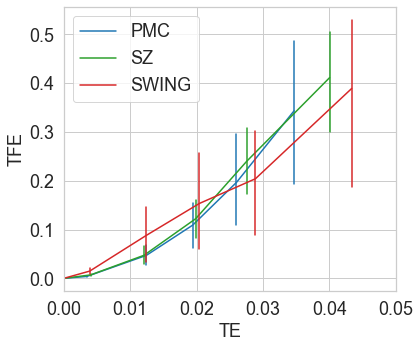

In [97]:
plot_te_tfe('aus')

In [ ]:
plot_te_tfe('aus')
plot_te_tfe_pweather()

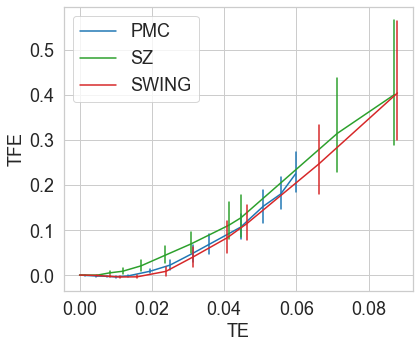

In [55]:
plot_te_tfe_from_precomp('ETTM1', 0.1)

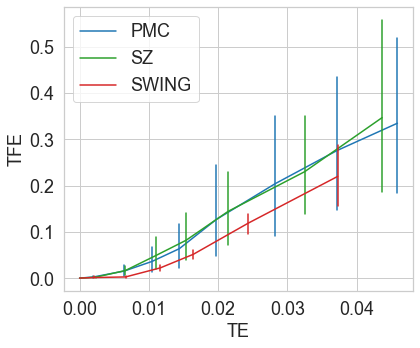

In [56]:
plot_te_tfe_from_precomp('ETTM2', 0.05)

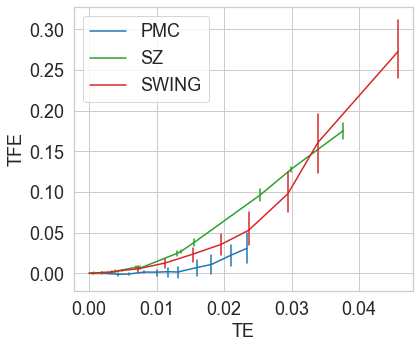

In [59]:
plot_te_tfe_from_precomp('SOLAR', 0.05)

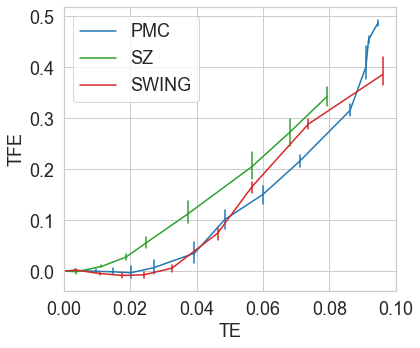

In [74]:
plot_te_tfe_from_precomp('WIND', 0.1)

D:\Anaconda\envs\dart\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
D:\Anaconda\envs\dart\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
D:\Anaconda\envs\dart\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

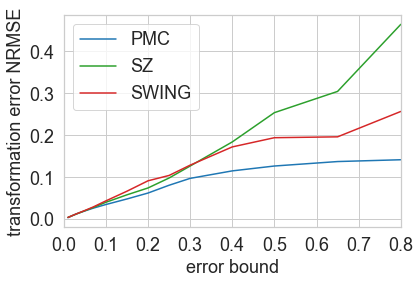

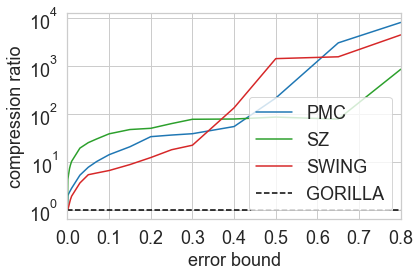

In [13]:
df = pd.read_csv('../results/te/transformation_error.csv')
plot_te(df, 'aus')
df = pd.read_csv('../results/cr/all_cr.csv')
plot_cr(df, 'aus')

D:\Anaconda\envs\dart\lib\site-packages\ipykernel_launcher.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


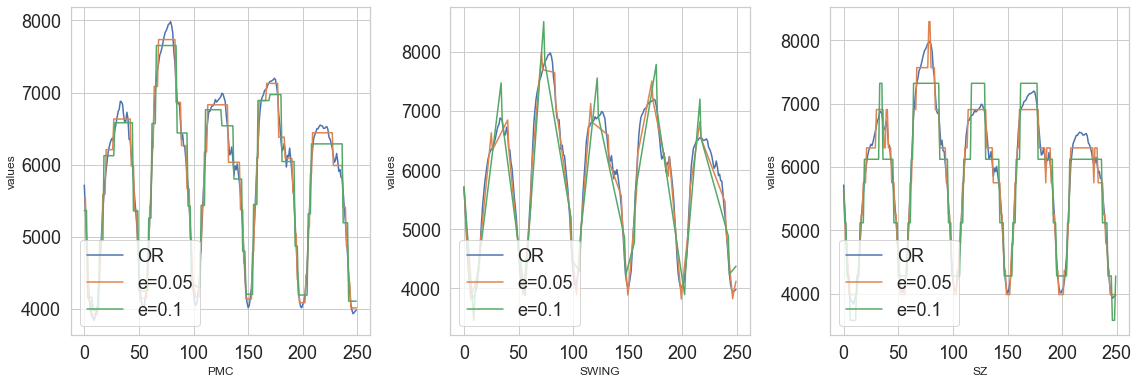

In [7]:
plot_compressed_data('aus', '../data/compressed/%s/aus_electrical_demand_points.parquet', 'y', (5.0, 10.0))

In [37]:
t = pd.read_csv('../results/tfe/all_models_results_.csv')
hue_order = t.model.unique()
hue_order.sort()
data_map = {'ETTM1':'ETTm1', 'ETTM2':'ETTm2', 'SOLAR': 'Solar', 'AUS': 'ElecDem', 'WEATHER': 'Weather', 'WIND':'Wind'}

def plot_te_tfe_per_model(data_name, eb_bound, ax):
    all_results = pd.read_csv('../results/tfe/all_models_results_.csv')
    all_results.eb = np.round(all_results.eb.values, 2)
    if 'WEATHER' in data_name:
        all_results = pd.read_csv('../results/tfe/pweather_results.csv')

    all_results = all_results[(all_results.data == data_name) & (all_results.eb <= eb_bound) & (all_results.eb > 0) &  (all_results.te_metric=='nrmse')]

    if 'SOLAR' in data_name:
        all_results.at[(all_results.model == 'GRU'), 'TFE'] = 0.0


    ax = sns.barplot(data=all_results, x='eb', y='TFE', hue='model', ci=None, hue_order=hue_order, ax=ax)
    ax.set(ylabel='TFE', xlabel=f'EB on {data_map[data_name]}')
    # xlim = ax.get_xlim()
    # ylim = ax.get_ylim()
    # x_pos = xlim[0] + 0.02 * (xlim[1] - xlim[0])   # Adjust 0.02 if needed to move the title left or right
    # y_pos = ylim[1] - 0.1 * (ylim[1] - ylim[0])   # Adjust 0.05 if needed to move the title up or down
    #
    # ax.text(x_pos, y_pos, data_map[data_name], fontsize=20, ha='left', va='top', backgroundcolor=(1, 1, 1, 0.5))




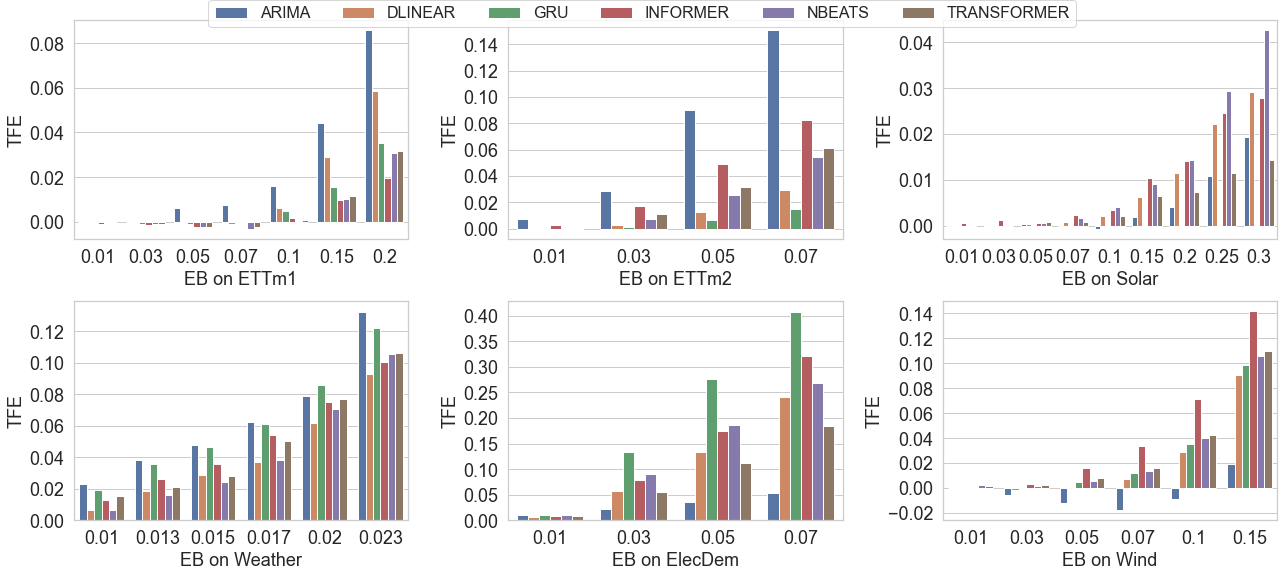

In [41]:
sns.set(rc={"figure.figsize":(6*3, 8)})
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['savefig.transparent'] = True
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3)

plot_te_tfe_per_model('ETTM1', 0.22, axes[0,0])
plot_te_tfe_per_model('ETTM2', 0.09, axes[0,1])
plot_te_tfe_per_model('SOLAR', 0.37, axes[0,2])
plot_te_tfe_per_model('WEATHER', 0.023, axes[1,0])
plot_te_tfe_per_model('AUS', 0.07, axes[1,1])
plot_te_tfe_per_model('WIND', 0.17, axes[1,2])

for ax in axes.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    if ax.get_legend():
        ax.get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()  # you can get handles and labels from any of the subplots
fig.legend(handles, labels, fontsize='16', loc='upper center', ncol=6, borderaxespad=0)  # 'ncol' specifies the number of columns in the legend
# plt.legend(title='', fontsize='18', loc='upper left')

plt.tight_layout()
plt.savefig(f'../figures/tfe_per_model.pdf')
plt.show()

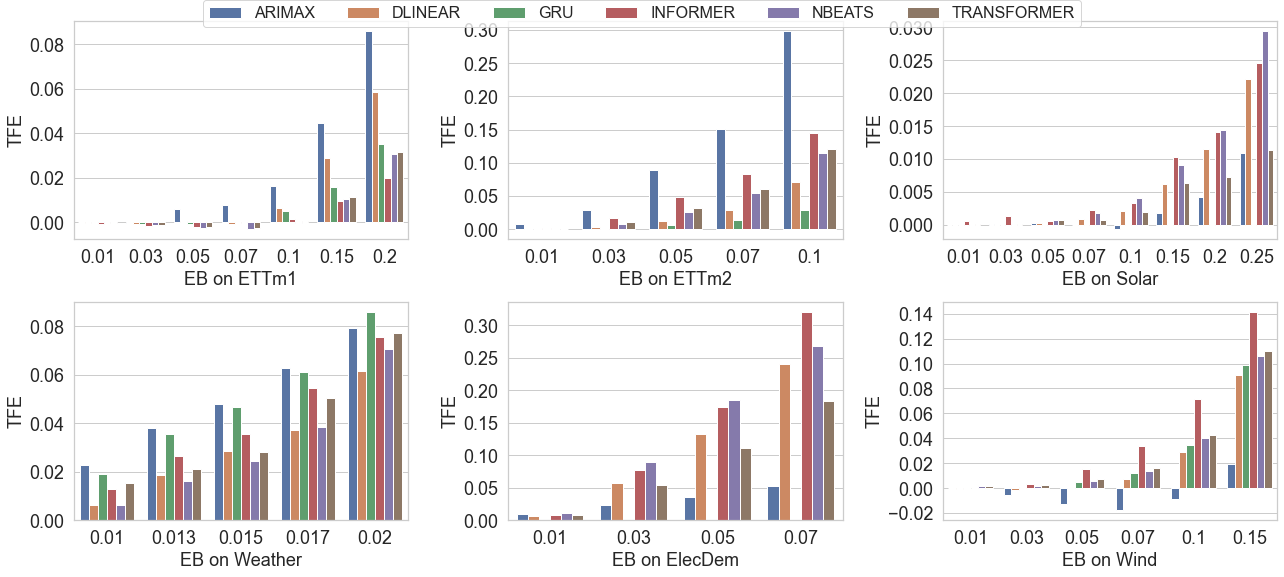

In [176]:
t = pd.read_csv('../results/tfe/models_results.csv')
hue_order = t.model.unique()
hue_order.sort()
data_map = {'ETTM1':'ETTm1', 'ETTM2':'ETTm2', 'SOLAR': 'Solar', 'AUS': 'ElecDem', 'WEATHER': 'Weather', 'WIND':'Wind'}

def plot_new_te_tfe_per_model(data_name, eb_bound, ax):
    all_results = pd.read_csv('../results/tfe/models_results.csv')
    all_results.eb = np.round(all_results.eb.values, 3)

    all_results = all_results[(all_results.data == data_name) & (all_results.eb <= eb_bound) & (all_results.eb > 0) &  (all_results.te_metric=='nrmse')]

    if 'SOLAR' in data_name or 'AUS' in data_name:
        all_results.at[(all_results.model == 'GRU'), 'TFE'] = 0.0


    ax = sns.barplot(data=all_results, x='eb', y='TFE', hue='model', ci=None, hue_order=hue_order, ax=ax)
    ax.set(ylabel='TFE', xlabel=f'EB on {data_map[data_name]}')
    fr = all_results[['eb', 'TFE', 'model', 'compression', 'forecasting error']].groupby(['eb', 'model']).mean().reset_index()
    fr['data'] = data_name
    return fr

sns.set(rc={"figure.figsize":(6*3, 8)})
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['savefig.transparent'] = True
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3)

ettm1_r = plot_new_te_tfe_per_model('ETTM1', 0.22, axes[0,0])
ettm2_r = plot_new_te_tfe_per_model('ETTM2', 0.1, axes[0,1])
solar_r = plot_new_te_tfe_per_model('SOLAR', 0.28, axes[0,2])
weather_r = plot_new_te_tfe_per_model('WEATHER', 0.02, axes[1,0])
aus_r = plot_new_te_tfe_per_model('AUS', 0.07, axes[1,1])
wind_r = plot_new_te_tfe_per_model('WIND', 0.17, axes[1,2])

for ax in axes.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    if ax.get_legend():
        ax.get_legend().remove()

handles, labels = axes[0, 0].get_legend_handles_labels()  # you can get handles and labels from any of the subplots
fig.legend(handles, labels, fontsize='16', loc='upper center', ncol=6, borderaxespad=0)  # 'ncol' specifies the number of columns in the legend
# plt.legend(title='', fontsize='18', loc='upper left')

plt.tight_layout()
plt.savefig(f'../figures/new_tfe_per_model.pdf')
plt.show()

In [178]:
pd.concat([ettm1_r, ettm2_r, solar_r, weather_r,aus_r, wind_r]).to_csv('../results/tfe/for_ranking.csv', index=False)

# Retraining results

In [2]:
from matplotlib.ticker import FormatStrFormatter
arima_retrain_results = pd.read_csv('../results/tfe/arima_retrain_results.csv')
dlinear_retrain_results = pd.read_csv('../results/tfe/dlinear_retrain_results.csv')
arima_retrain_results['model'] = 'ARIMAX'
dlinear_retrain_results['model'] = 'DLINEAR'
joined_results = pd.concat([arima_retrain_results, dlinear_retrain_results])
data_map = {'ettm1': 'ETTm1', 'ettm2': 'ETTm2'}

D:\Anaconda\envs\dart\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda\envs\dart\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


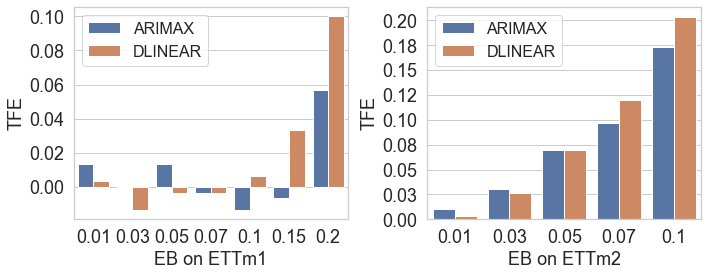

In [15]:
def plot_new_te_tfe_per_model(joined_results, data_name, eb_bound, ax):
    x = joined_results.eb.values
    joined_results.eb = np.where(x >= 1.0, x*0.01, x)
    joined_results.eb = np.round(joined_results.eb.values, 2)
    joined_results = joined_results[(joined_results.eb <= eb_bound) & (joined_results.data == data_name)]
    retrain_results = pd.DataFrame()
    for model in joined_results.model.unique():
        model_results = joined_results[joined_results.model == model]
        model_tfe = get_tfe(model_results)
        retrain_results = pd.concat([retrain_results, model_tfe])

    retrain_results = retrain_results[retrain_results.eb > 0]
    retrain_results.tfe = np.round(retrain_results.tfe.values, 2)

    ax = sns.barplot(data=retrain_results, x='eb', y='tfe', hue='model', ci=None, ax=ax)
    ax.set(ylabel='TFE', xlabel=f'EB on {data_map[data_name]}')
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    # if ax.get_legend():
    #     ax.get_legend().remove()
    ax.legend(title='', fontsize='16')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


sns.set(rc={"figure.figsize":(5*2, 4)})
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['savefig.transparent'] = True
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2)

plot_new_te_tfe_per_model(joined_results, 'ettm1', 0.2, ax1)
plot_new_te_tfe_per_model(joined_results, 'ettm2', 0.1, ax2)

# handles, labels = ax1.get_legend_handles_labels()  # you can get handles and labels from any of the subplots
# fig.legend(handles, labels, fontsize='16', loc='lower center', ncol=2, borderaxespad=0.)

plt.tight_layout()
plt.savefig(f'../figures/retrain_tfe_per_model.pdf')
plt.show()

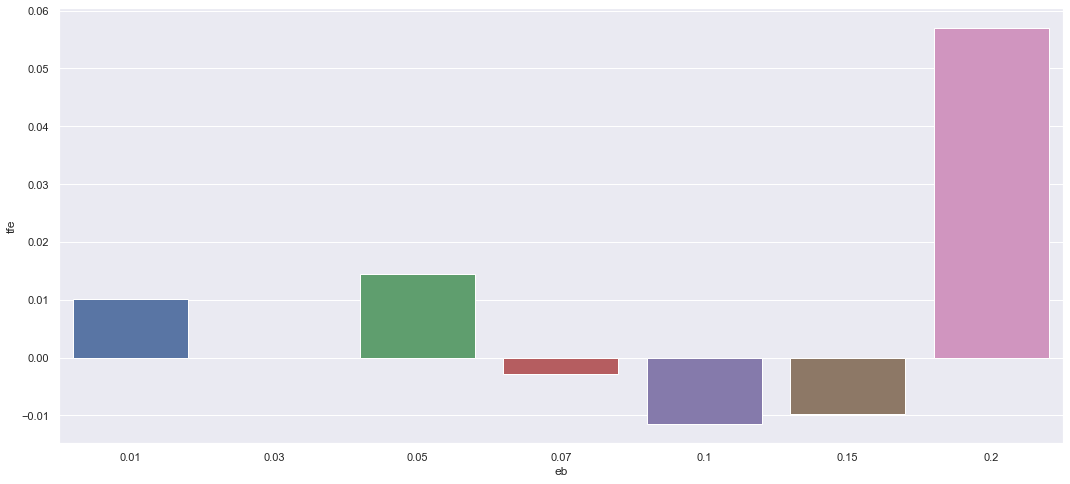

,error,mae,rmse,nrmse,rse,corr,data_corr,eb,eblc,data,tfe
1,0.001670,0.089440,0.121257,0.054695,0.318705,0.949550,0.999953,0.01,sz,ettm1,0.009378
2,0.005031,0.089944,0.122301,0.055166,0.321449,0.948914,0.999572,0.03,sz,ettm1,0.018069
3,0.008321,0.090756,0.122911,0.055441,0.323053,0.948343,0.998839,0.05,sz,ettm1,0.023149
4,0.011922,0.093041,0.124886,0.056332,0.328245,0.946184,0.997638,0.07,sz,ettm1,0.039592
5,0.016981,0.097073,0.130055,0.058663,0.341830,0.941835,0.995373,0.10,sz,ettm1,0.082617
6,0.023518,0.098091,0.129586,0.058452,0.340598,0.942471,0.991099,0.15,sz,ettm1,0.078716
7,0.030747,0.106569,0.139752,0.063037,0.367315,0.935686,0.984847,0.20,sz,ettm1,0.163334
11,0.001384,0.089497,0.122046,0.055051,0.320778,0.949272,0.999968,0.01,pmc,ettm1,0.015944
12,0.004637,0.088744,0.120031,0.054142,0.315484,0.950615,0.999635,0.03,pmc,ettm1,-0.000823
13,0.007517,0.088360,0.119868,0.054068,0.315055,0.950738,0.999041,0.05,pmc,ettm1,-0.002181


In [132]:
data_name = 'ettm1'
eb_bound=0.2

sns.set(rc={"figure.figsize":(6*3, 8)})
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['savefig.transparent'] = True
sns.set_theme(style="whitegrid")

retrain_results = pd.read_csv('../results/tfe/arima_retrain_results.csv')
x = retrain_results.eb.values
retrain_results.eb = np.where(x >= 1.0, x*0.01, x)
retrain_results.eb = np.round(retrain_results.eb.values, 2)

retrain_results = retrain_results[(retrain_results.data == data_name)]
retrain_results = get_tfe(retrain_results)
retrain_results = retrain_results[(retrain_results.eb <= eb_bound) & (retrain_results.eb > 0)]

ax = sns.barplot(data=retrain_results, x='eb', y='tfe', ci=None)
    # ax.set(ylabel='TFE', xlabel=f'EB on {data_map[data_name]}')
plt.show()

retrain_results

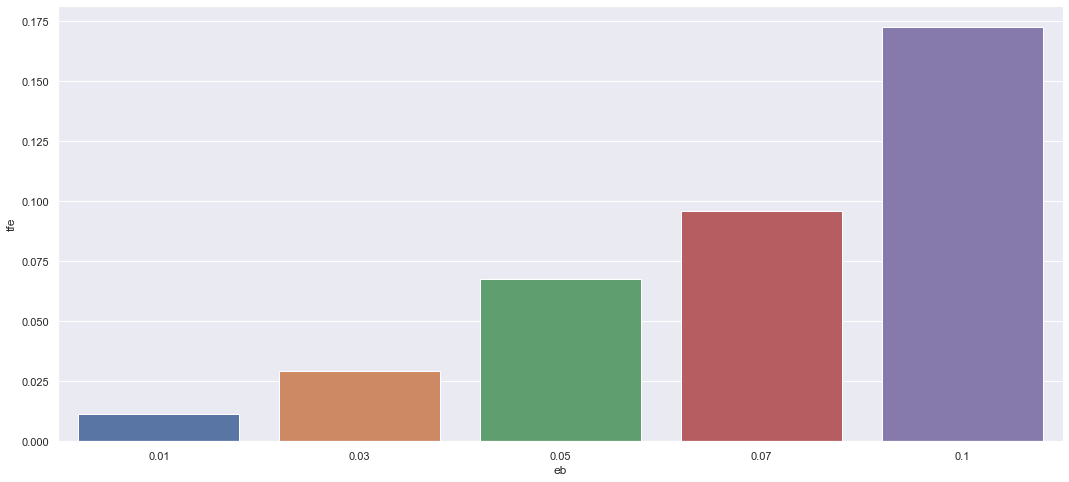

,error,mae,rmse,nrmse,rse,corr,data_corr,eb,eblc,data,tfe
32,0.002304,0.103870,0.152182,0.045198,0.245363,0.970568,0.999923,0.01,sz,ettm2,0.010429
33,0.006608,0.109902,0.156696,0.046538,0.252641,0.968832,0.999359,0.03,sz,ettm2,0.040400
34,0.011047,0.120884,0.165289,0.049091,0.266496,0.964436,0.998234,0.05,sz,ettm2,0.097458
35,0.015360,0.126203,0.168990,0.050190,0.272463,0.963047,0.996554,0.07,sz,ettm2,0.122029
36,0.021435,0.134575,0.174754,0.051902,0.281757,0.959783,0.993504,0.10,sz,ettm2,0.160303
42,0.001944,0.104300,0.152601,0.045322,0.246039,0.970372,0.999944,0.01,pmc,ettm2,0.013212
43,0.006423,0.109824,0.155421,0.046160,0.250587,0.968977,0.999391,0.03,pmc,ettm2,0.031941
44,0.010461,0.114698,0.159249,0.047297,0.256758,0.967169,0.998385,0.05,pmc,ettm2,0.057357
45,0.014395,0.120107,0.163752,0.048634,0.264018,0.964890,0.996940,0.07,pmc,ettm2,0.087253
46,0.019738,0.128824,0.171790,0.051021,0.276978,0.961362,0.994239,0.10,pmc,ettm2,0.140623


In [133]:
data_name = 'ettm2'
eb_bound=0.1
retrain_results = pd.read_csv('../results/tfe/arima_retrain_results.csv')
x = retrain_results.eb.values
retrain_results.eb = np.where(x >= 1.0, x*0.01, x)
retrain_results.eb = np.round(retrain_results.eb.values, 2)

retrain_results = retrain_results[(retrain_results.data == data_name)]
retrain_results = get_tfe(retrain_results)
retrain_results = retrain_results[(retrain_results.eb <= eb_bound) & (retrain_results.eb > 0)]

sns.barplot(data=retrain_results, x='eb', y='tfe', ci=None)
    # ax.set(ylabel='TFE', xlabel=f'EB on {data_map[data_name]}')
plt.show()

retrain_results

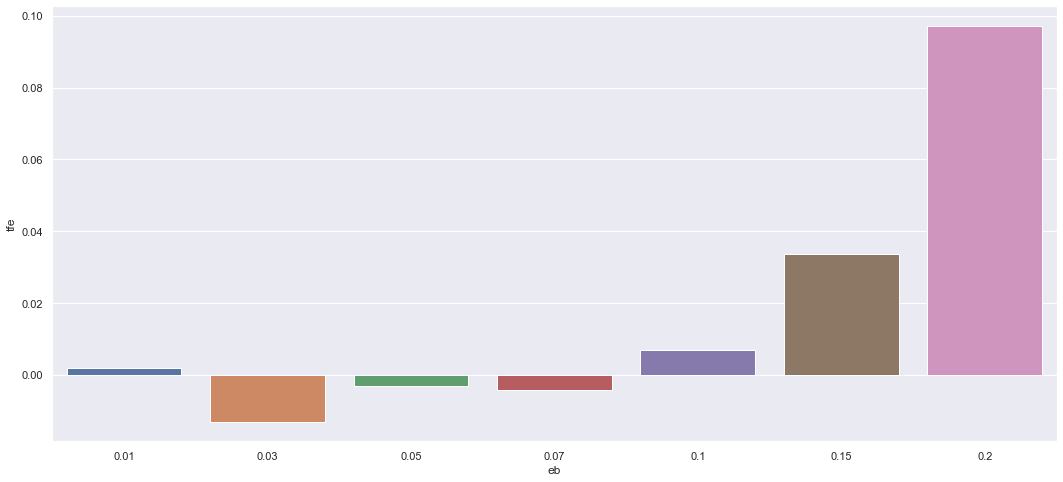

,error,mae,rmse,nrmse,rse,corr,data_corr,eb,eblc,data,tfe
1,0.002125,0.075891,0.105589,0.052352,0.308114,0.953680,0.999932,0.01,pmc,ettm1,-0.019385
2,0.006456,0.075391,0.105450,0.052283,0.307708,0.953945,0.999367,0.03,pmc,ettm1,-0.020677
3,0.010003,0.075174,0.105377,0.052247,0.307497,0.954310,0.998480,0.05,pmc,ettm1,-0.021350
4,0.013527,0.077019,0.106354,0.052732,0.310348,0.954591,0.997218,0.07,pmc,ettm1,-0.012276
5,0.018657,0.074887,0.105524,0.052320,0.307924,0.954156,0.994701,0.10,pmc,ettm1,-0.019989
6,0.027473,0.076325,0.107275,0.053189,0.313036,0.952129,0.988474,0.15,pmc,ettm1,-0.003722
7,0.036370,0.075938,0.108361,0.053727,0.316202,0.949458,0.979711,0.20,pmc,ettm1,0.006356
9,0.002393,0.081029,0.110890,0.054981,0.323583,0.953540,0.999913,0.01,sz,ettm1,0.029845
10,0.007088,0.076849,0.107068,0.053086,0.312432,0.953269,0.999240,0.03,sz,ettm1,-0.005644
11,0.011749,0.077382,0.107583,0.053341,0.313932,0.952365,0.997926,0.05,sz,ettm1,-0.000869


In [135]:
data_name = 'ettm1'
eb_bound=0.2
retrain_results = pd.read_csv('../results/tfe/dlinear_retrain_results.csv')
x = retrain_results.eb.values
retrain_results.eb = np.where(x >= 1.0, x*0.01, x)
retrain_results.eb = np.round(retrain_results.eb.values, 2)

retrain_results = retrain_results[(retrain_results.data == data_name)]
retrain_results = get_tfe(retrain_results)
retrain_results = retrain_results[(retrain_results.eb <= eb_bound) & (retrain_results.eb > 0)]

sns.barplot(data=retrain_results, x='eb', y='tfe', ci=None)
    # ax.set(ylabel='TFE', xlabel=f'EB on {data_map[data_name]}')
plt.show()
retrain_results

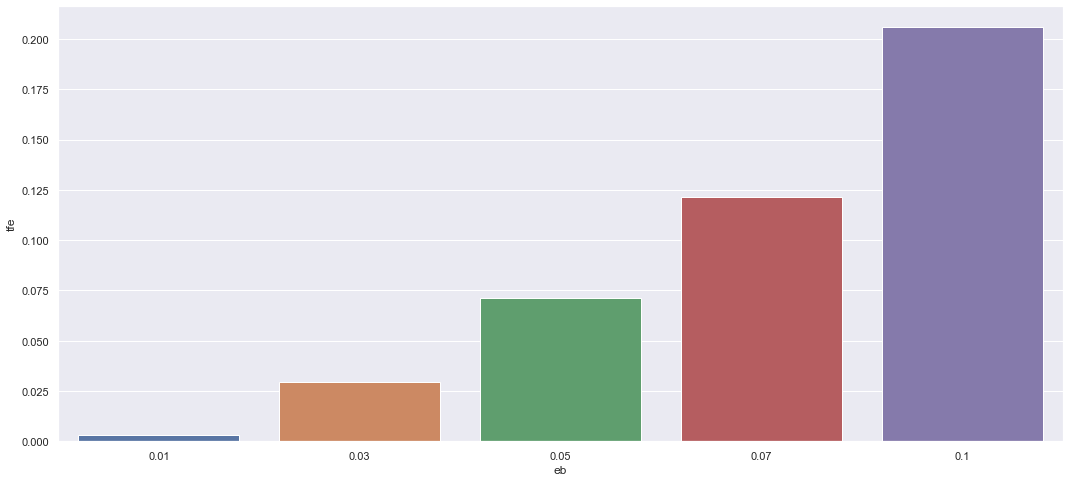

,error,mae,rmse,nrmse,rse,corr,data_corr,eb,eblc,data,tfe
26,0.002850,0.102127,0.156217,0.046517,0.253655,0.967438,0.999906,0.01,pmc,ettm2,0.004271
27,0.008451,0.107119,0.160812,0.047885,0.261116,0.965480,0.999176,0.03,pmc,ettm2,0.033810
28,0.013574,0.113308,0.166924,0.049705,0.271040,0.962749,0.997873,0.05,pmc,ettm2,0.073102
29,0.018518,0.119207,0.172735,0.051435,0.280476,0.959987,0.996037,0.07,pmc,ettm2,0.110458
30,0.025181,0.127630,0.182320,0.054290,0.296041,0.955073,0.992660,0.10,pmc,ettm2,0.172083
34,0.003009,0.102504,0.156420,0.046577,0.253984,0.967358,0.999897,0.01,sz,ettm2,0.005574
35,0.008688,0.109098,0.162328,0.048336,0.263578,0.964926,0.999139,0.03,sz,ettm2,0.043556
36,0.014393,0.116290,0.169201,0.050383,0.274738,0.961794,0.997655,0.05,sz,ettm2,0.087742
37,0.020273,0.124070,0.177130,0.052744,0.287612,0.958469,0.995344,0.07,sz,ettm2,0.138713
38,0.027897,0.135065,0.187247,0.055757,0.304040,0.953888,0.991343,0.10,sz,ettm2,0.203756


In [136]:
data_name = 'ettm2'
eb_bound=0.1
retrain_results = pd.read_csv('../results/tfe/dlinear_retrain_results.csv')
x = retrain_results.eb.values
retrain_results.eb = np.where(x >= 1.0, x*0.01, x)
retrain_results.eb = np.round(retrain_results.eb.values, 2)

retrain_results = retrain_results[(retrain_results.data == data_name)]
retrain_results = get_tfe(retrain_results)
retrain_results = retrain_results[(retrain_results.eb <= eb_bound) & (retrain_results.eb > 0)]

sns.barplot(data=retrain_results, x='eb', y='tfe', ci=None)
    # ax.set(ylabel='TFE', xlabel=f'EB on {data_map[data_name]}')
plt.show()
retrain_results

In [197]:
df = pd.read_csv('../results/tfe/for_ranking.csv')
df = df[~((df.model == 'GRU') & ((df.data == 'SOLAR') | (df.data == 'AUS')))]
df

,eb,model,TFE,forecasting error,data
0,0.01,ARIMAX,0.000071,0.054190,ETTM1
1,0.01,DLINEAR,-0.000104,0.050452,ETTM1
2,0.01,GRU,0.000037,0.065440,ETTM1
3,0.01,INFORMER,-0.000920,0.066577,ETTM1
4,0.01,NBEATS,-0.000157,0.061511,ETTM1
...,...,...,...,...,...
205,0.15,DLINEAR,0.090743,0.036230,WIND
206,0.15,GRU,0.098703,0.036401,WIND
207,0.15,INFORMER,0.141619,0.038120,WIND
208,0.15,NBEATS,0.106020,0.035583,WIND


In [198]:
df = df.groupby(['data', 'model']).mean().reset_index()
idx = df.groupby(['data'])['TFE'].idxmin()
df.loc[idx]

,data,model,eb,TFE,forecasting error
0,AUS,ARIMAX,0.040000,0.030246,0.083532
8,ETTM1,INFORMER,0.087143,0.003741,0.066906
13,ETTM2,GRU,0.052000,0.010037,0.091804
17,SOLAR,ARIMAX,0.107500,0.002082,0.163919
23,WEATHER,DLINEAR,0.015000,0.030473,0.071853
28,WIND,ARIMAX,0.068333,-0.004170,0.035580


In [199]:
df

,data,model,eb,TFE,forecasting error
0,AUS,ARIMAX,0.040000,0.030246,0.083532
1,AUS,DLINEAR,0.040000,0.109459,0.055831
2,AUS,INFORMER,0.040000,0.145410,0.046157
3,AUS,NBEATS,0.040000,0.138738,0.046607
4,AUS,TRANSFORMER,0.040000,0.089822,0.045786
5,ETTM1,ARIMAX,0.087143,0.022898,0.055427
6,ETTM1,DLINEAR,0.087143,0.013234,0.051160
7,ETTM1,GRU,0.087143,0.007778,0.065964
8,ETTM1,INFORMER,0.087143,0.003741,0.066906
9,ETTM1,NBEATS,0.087143,0.004863,0.061831


In [200]:
idx = df.groupby(['data'])['forecasting error'].idxmin()
df.loc[idx]

,data,model,eb,TFE,forecasting error
4,AUS,TRANSFORMER,0.040000,0.089822,0.045786
6,ETTM1,DLINEAR,0.087143,0.013234,0.051160
14,ETTM2,INFORMER,0.052000,0.059321,0.047552
20,SOLAR,NBEATS,0.107500,0.007466,0.080628
23,WEATHER,DLINEAR,0.015000,0.030473,0.071853
32,WIND,NBEATS,0.068333,0.028337,0.032708


In [212]:
df = pd.read_csv('../results/tfe/for_ranking.csv')
df = df[~((df.model == 'GRU') & ((df.data == 'SOLAR') | (df.data == 'AUS')))]
r = df.groupby(['data', 'model'])['forecasting error'].mean()
idx = r.groupby(['data']).idxmin()
r.loc[idx]

data     model      
AUS      TRANSFORMER    0.045786
ETTM1    DLINEAR        0.051160
ETTM2    INFORMER       0.047552
SOLAR    NBEATS         0.080628
WEATHER  DLINEAR        0.071853
WIND     NBEATS         0.032708
Name: forecasting error, dtype: float64

In [213]:
df = pd.read_csv('../results/tfe/for_ranking.csv')
df = df[~((df.model == 'GRU') & ((df.data == 'SOLAR') | (df.data == 'AUS')))]
r = df.groupby(['data', 'model'])['TFE'].mean()
idx = r.groupby(['data']).idxmin()
r.loc[idx]

data     model   
AUS      ARIMAX      0.030246
ETTM1    INFORMER    0.003741
ETTM2    GRU         0.010037
SOLAR    ARIMAX      0.002082
WEATHER  DLINEAR     0.030473
WIND     ARIMAX     -0.004170
Name: TFE, dtype: float64